### This File serves as a guide to blinkit's ability in parsing our blink data files and segmenting blinks

In [1]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

import settings
from blinkit import io
from blinkit import data as data
from blinkit import blink_params

import scipy.signal as signal

Reading File and Cleaning EOG data

In [2]:
"""
Selecting the file to open
"""
current_filename = "Device_1_Volts.xls"
dir = ['Chandrika_Yadav', 'ST']
file_path = f"{settings.PATH_TO_DATA}/21-06-22/{dir[1]}/{current_filename}"

In [3]:
"""
Read and clean the data for plain EOG data
"""

df_eog = io.read_Voltsxls(file_path)

In [4]:
"""
As a demonstration, Channel 1 is taken as the primary EOG signal, 
with only the specified window to exclude initial 
spikes from calibration/recording errors
"""
use_data = df_eog["CH1"]
use_data = list(use_data[6000:30000])

In [5]:
"""
Applying low pass filter smoothening on the data. 
Here, blinkit.sp_filters has compiled the low pass and high pass
filters needed, though I haven't used them here.
"""
cutoff=0.05
b, a = signal.butter(2, cutoff, btype='lowpass') #low pass filter
filtered_data= signal.filtfilt(b, a, use_data)

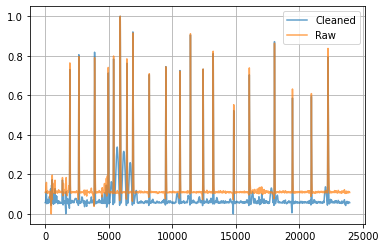

In [6]:
"""
Cleaning EOG data with neurokit's method
"""
eog_cleaned = nk.eog_clean(filtered_data, sampling_rate=100, method='neurokit')
plt.plot(data.detrend_standardize( eog_cleaned), alpha =0.7, label = "Cleaned")
plt.plot(data.detrend_standardize( filtered_data), alpha =0.7, label = "Raw")
plt.legend()
plt.grid()

Segmenting and Characterizing blinks with their basic features

In [7]:
"""
Using neurokit, we detect the blinks and obtain 
their start, end, and peak point
""" 

blinks = nk.signal_findpeaks(eog_cleaned, relative_height_min=0)
print(f"{len(blinks['Peaks'])} Blinks found")
df_blinks = pd.DataFrame(blinks)
df_blinks.head()

41 Blinks found


,Peaks,Distance,Height,Width,Onsets,Offsets
0,281,285.0,0.000135,235.070728,194,385
1,547,266.0,0.000207,190.225105,518,626
2,1345,798.0,0.000159,119.299726,1169,1390
3,1647,302.0,0.000192,99.048044,1614,1737
4,1934,285.0,0.000664,32.764308,1896,1990


In [8]:
"""
Here an umbrella function is called that determines
the various characteristics of each blink
"""
blink_params.blink_stats.perform(eog_cleaned, df_blinks)
df_blinks.head()

,Peaks,Distance,Height,Width,Onsets,Offsets,0width,0.2width,0.5width,0.95width,spmax_close,spmin_open,pre_interval,post_interval,moment1,moment2,moment3,moment4
0,281,285.0,0.000135,235.070728,194,385,439.805591,410.179627,235.070728,41.802258,19,171,<NA>,133,0.0,4.714057e-10,-1.300828e-14,8.171401e-19
1,547,266.0,0.000207,190.225105,518,626,1428.645228,309.868251,190.225105,11.785840,16,39,133,543,0.0,1.251994e-09,1.044270e-14,3.677503e-18
2,1345,798.0,0.000159,119.299726,1169,1390,580.419120,551.049728,119.299726,14.751650,164,196,543,224,0.0,1.897035e-09,-4.154046e-14,1.166916e-17
3,1647,302.0,0.000192,99.048044,1614,1737,500.831337,391.792942,99.048044,14.069841,18,43,224,159,0.0,1.211659e-09,-1.602879e-15,2.729329e-18
4,1934,285.0,0.000664,32.764308,1896,1990,2104.056912,50.811141,32.764308,8.732740,24,51,159,21,0.0,5.325324e-08,6.873776e-12,5.066981e-15


Text(0.5, 0.98, 'A single blink')

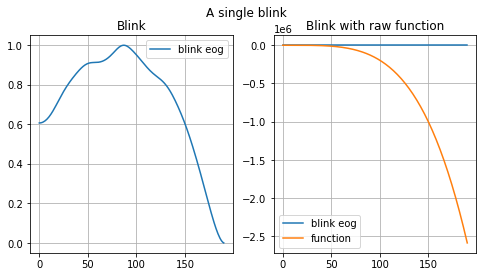

In [9]:
"""
Here we show a rough comparison between a hand-written
list of paramteres to one of the selected fit functions

We will be fitting blinks with least-squares later on
"""

from blinkit import blink_fit, plot

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
curr_blink = df_blinks.iloc[0]
blink_range = eog_cleaned[int(curr_blink["Onsets"]): int(curr_blink["Offsets"])]
norm_data = data.normalize(blink_range)
ax[0].plot(norm_data, label = "blink eog")
ax[0].set_title("Blink")
ax[0].grid()
ax[0].legend()

x = range(len(norm_data))
p0 = [0.0005, 0.003, -0.002, 0.0005, 0]
temp_func = blink_fit.fitfunc_wrapper(blink_fit.paper_func.func, p0)
ax[1].plot(norm_data, label = "blink eog")
ax[1].plot(temp_func(x), label = "function")
ax[1].legend()
ax[1].grid()
ax[1].set_title("Blink with raw function")
plt.suptitle("A single blink")

In [10]:
"""
Here a general fucntion is called that fits all blinks 
to the specified fit function
"""
fits = blink_fit.gen_fits(eog_cleaned, df_blinks, blink_fit.paper_func, p0 = None)
fits.head()

c:\users\vishn\documents\workspace\blink_research\blinks_main\blinkit\blinkit\blink_fit.py:49: RuntimeWarning: divide by zero encountered in power
  return (a0 * np.power(x, 2)) + (a1 * np.power(x, 3)) + (a2 * np.power(x, 4)) + np.exp(-b * np.power(x, c))
c:\Users\vishn\.pyenv\pyenv-win\versions\3.9.5\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,param_0,param_1,param_2,param_3,param_4,sqr_dist
0,0.000108,-1.106604e-06,2.192274e-09,0.631142,-0.190465,0.455433
1,-0.000089,-1.397048e-06,1.584450e-08,14222.899451,-3.779083,0.446421
2,-0.000092,1.457726e-06,-5.099636e-09,1.167731,-0.183246,1.234300
3,-0.000039,-9.478935e-07,6.279709e-09,17457.981768,-3.661337,0.327013
4,0.002070,-5.088783e-05,3.111378e-07,17.695665,3.805602,1.907270


param_0     8.982882e-05
param_1    -4.912167e-07
param_2     7.094065e-10
param_3     9.432024e+00
param_4    -3.285566e-01
sqr_dist    4.077828e-02
Name: 31, dtype: float64


c:\users\vishn\documents\workspace\blink_research\blinks_main\blinkit\blinkit\blink_fit.py:49: RuntimeWarning: divide by zero encountered in power
  return (a0 * np.power(x, 2)) + (a1 * np.power(x, 3)) + (a2 * np.power(x, 4)) + np.exp(-b * np.power(x, c))


Text(0.5, 1.0, 'Comparison of blink and fit for blink 31')

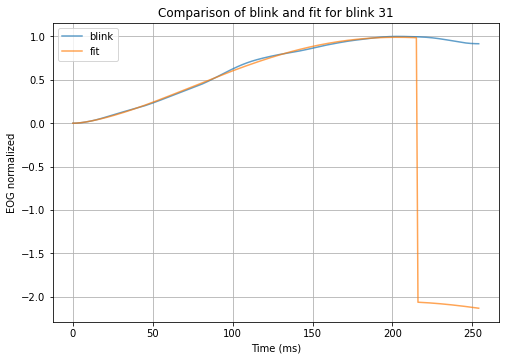

In [11]:
"""
We compare one of the blinks with their respective
fits
"""

val = np.where(fits['sqr_dist'] == np.min(fits['sqr_dist']))[0][0]
print(fits.iloc[val, :])

plt.figure(figsize = (8, 5.5))
plot.plot_compare(eog_cleaned, fits, df_blinks, 31, blink_fit.paper_func)

plt.ylabel("EOG normalized")
plt.xlabel("Time (ms)")
plt.grid()
plt.legend()
plt.title(f"Comparison of blink and fit for blink {val}")

In [12]:
"""
Here we label blinks as per the 
double-blinks heuristic

For more info, check the documentation of the 
below function
"""
blink_labels = blink_params.label_doubleblinks(df_blinks)

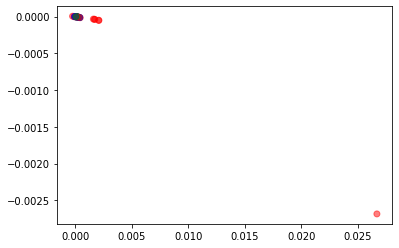

In [17]:
"""
When plotting two of the fit parameters against each other,
we can see little separation with respect to the current
labelling method
"""

x = fits['param_0']
y = fits["param_1"]
z = fits['param_2']
blink_color = []
cols = ['red', 'blue', 'green']
for i in blink_labels:
    blink_color.append(cols[i])
plt.scatter(x, y, c = blink_color, alpha = 0.5)


Text(0.5, 0.5, 'test')

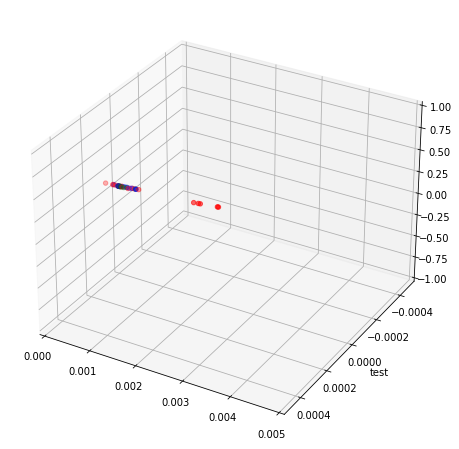

In [18]:
"""
This is the same plot but in 3 dimensions
"""

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c=blink_color, marker="o" )
ax.set_xlim([0, 0.005])
ax.set_ylim3d([0.0005, -0.0005])
ax.set_zlim3d([-1, 1])
ax.set_ylabel("test")

In [32]:
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from matplotlib import colors
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

In [30]:
num_params = blink_fit.paper_func.num_params
cols = [ f"param_{i}" for i in range(num_params)]
X_data = fits[cols]

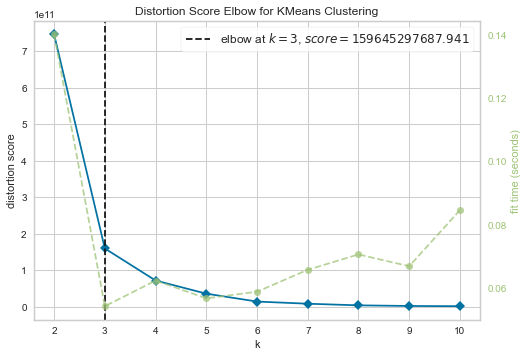

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
Elbow_M = KElbowVisualizer(KMeans(), k = 10)
Elbow_M.fit(X_data)
Elbow_M.show()

In [37]:
"""
Here we attempt to apply a clustering method on the data
Unlike K-Means, this method is more flexible to more-complex manifolds

However, we see the terrible differentiability of the data results in 
the clustering method only detecting outliers
"""
AC = AgglomerativeClustering(n_clusters=6)
yhat_AC = AC.fit_predict(X_data)
yhat_AC

array([1, 1, 1, 1, 1, 1, 5, 1, 5, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 3, 1, 0, 1, 1, 4, 1, 2],
      dtype=int64)

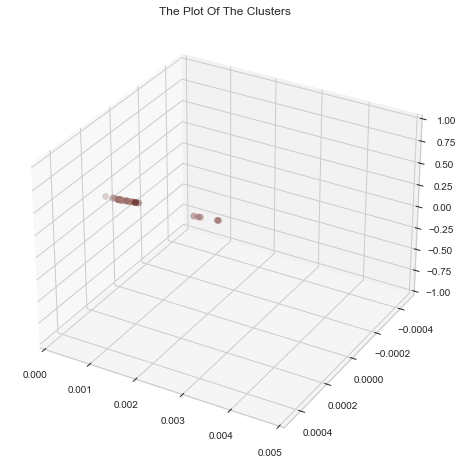

In [39]:
"""
These clusters are displayed

The colormap needs to be fixed
"""
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=yhat_AC, marker='o', cmap = cmap)
ax.set_title("The Plot Of The Clusters")

ax.set_xlim([0, 0.005])
ax.set_ylim3d([0.0005, -0.0005])
ax.set_zlim3d([-1, 1])

plt.show()
